In [77]:
import skimage
from skimage import io, filters
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import numpy as np
import cv2

# On va appliquer un filter de Sobel sur une image

On en profite pour montrer comment ouvrir un png avec `iread`

In [78]:
import os
filename = os.path.join(skimage.data_dir, 'camera.png')
camera = io.imread(filename)

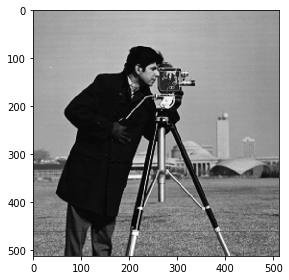

In [79]:
io.imshow(camera)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


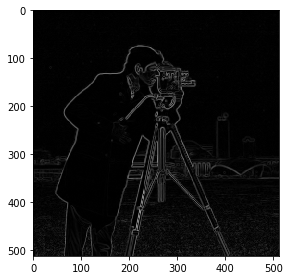

In [82]:
camera_sobel = filters.sobel(camera)
io.imshow(camera_sobel)
io.imsave("camera_sobel.png", camera_sobel)

# Binarisation d'images

On utilise la méthode d'Otsu pour déterminer le seuil obtimal.

/home/mfalce/Envs/formation_python/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: camera_threshold.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  after removing the cwd from sys.path.


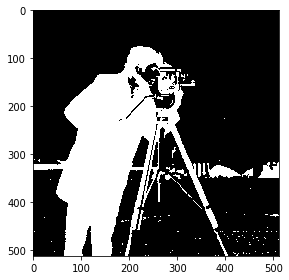

In [83]:
val = filters.threshold_otsu(camera)
mask = camera < val
io.imshow(mask)
io.imsave("camera_threshold.png", mask)

# Création d'un Histogram Of Gradients (HOG) 

Cette technique permet d'extraire des `features` d'une image. 

Source : https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html

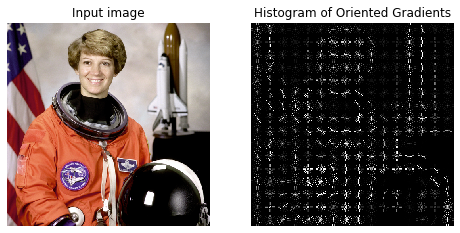

In [87]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


image = data.astronaut()

fd, hog_image = hog(image, orientations=8, pixels_per_cell=(32, 32),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.savefig("hog.png")
plt.show()

# Détection de visages dans des images

In [91]:
image = data.astronaut()

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

faces = face_cascade.detectMultiScale(
    image,
    scaleFactor=1.1,
    minNeighbors=5,
)

for (column, row, width, height) in faces:
    cv2.rectangle(
        image,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )

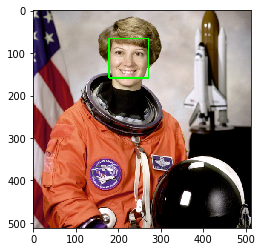

In [93]:
plt.imshow(image)
plt.savefig("face.png")

# Segmentation et séparation d'objets

Source : https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

In [96]:
image = data.coins()
# apply threshold
thresh = filters.threshold_otsu(image)
bw = closing(image > thresh, square(3))

# remove artifacts connected to image border
cleared = clear_border(bw)

# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`

image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

L'image a été nettoyée et segmentée. Il manque cepandant 2 pièces, car il y a un anque de contraste en haut à gauche de l'image. Il faudrait corriger la luminosité pour régler cela.

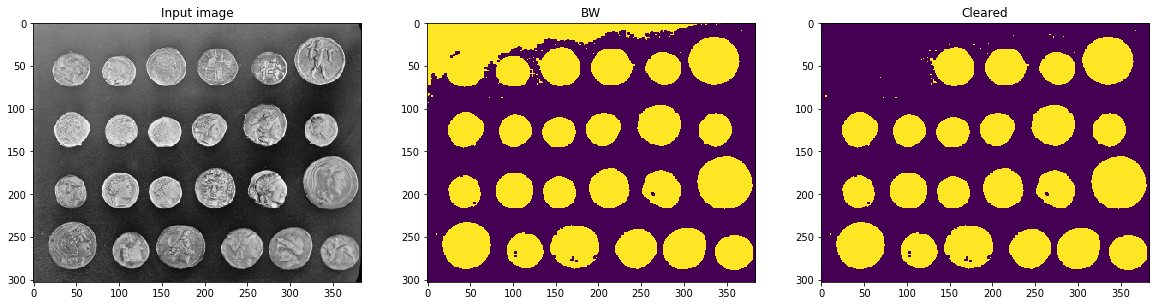

In [97]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 12))
ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title('Input image')

ax1.imshow(bw)
ax1.set_title('BW')

ax2.imshow(cleared)
ax2.set_title('Cleared');
fig.savefig("coins.png")

Maintenant que l'on a la segmantation, il est possible d'afficher les résultats

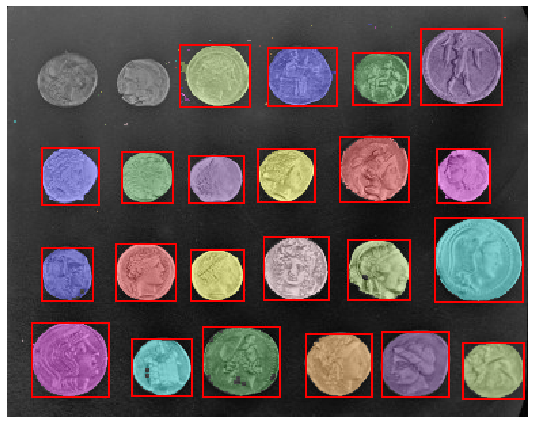

In [98]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 60:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
fig.savefig("coins_segmented.png")
plt.show()